<a href="https://colab.research.google.com/github/Tdas-christ/Reinforcement_Learning/blob/main/2348569_RL_Lab10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set up the environment
env = gym.make("CartPole-v1")
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n

# Hyperparameters
learning_rate = 0.001
gamma = 0.99
max_episodes = 500
max_steps_per_episode = 200

# Build a simple policy model
model = keras.Sequential([
    layers.Dense(24, activation="relu", input_shape=(num_states,)),
    layers.Dense(num_actions, activation="softmax")
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

def choose_action(state):
    state = np.expand_dims(state, axis=0)
    probs = model(state)
    action = np.random.choice(num_actions, p=probs.numpy()[0])
    return action, probs[0, action]

def compute_returns(rewards, gamma=0.99):
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    # Normalize returns for stability
    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    return returns

all_episode_rewards = []

for episode in range(max_episodes):
    state = env.reset()
    states, actions, rewards = [], [], []
    with tf.GradientTape() as tape:
        for step in range(max_steps_per_episode):
            action, action_prob = choose_action(state)
            next_state, reward, done, _ = env.step(action)
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state
            if done:
                break

        returns = compute_returns(rewards, gamma)

        # Compute loss: Sum over t of log(pi(a_t|s_t)) * G_t
        action_masks = tf.one_hot(actions, num_actions)

        states = np.array(states)
        logits = model(states, training=True)
        log_probs = tf.math.log(tf.reduce_sum(action_masks * logits, axis=1) + 1e-8)

        loss = -tf.reduce_mean(log_probs * returns)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    episode_reward = np.sum(rewards)
    all_episode_rewards.append(episode_reward)
    if (episode + 1) % 50 == 0:
        avg_reward = np.mean(all_episode_rewards[-50:])
        print(f"Episode {episode + 1}, Average Reward (last 50 eps): {avg_reward:.2f}")

env.close()


Episode 50, Average Reward (last 50 eps): 30.54
Episode 100, Average Reward (last 50 eps): 32.06
Episode 150, Average Reward (last 50 eps): 41.94
Episode 200, Average Reward (last 50 eps): 46.78
Episode 250, Average Reward (last 50 eps): 52.20
Episode 300, Average Reward (last 50 eps): 56.64
Episode 350, Average Reward (last 50 eps): 71.72
Episode 400, Average Reward (last 50 eps): 80.34
Episode 450, Average Reward (last 50 eps): 109.46
Episode 500, Average Reward (last 50 eps): 149.14


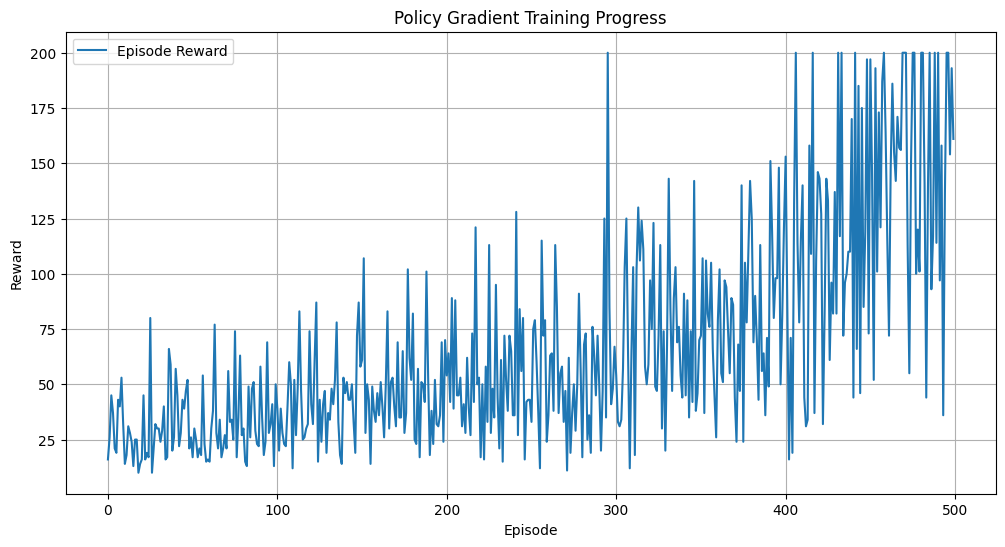

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(all_episode_rewards, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Policy Gradient Training Progress')
plt.grid(True)
plt.legend()
plt.show()


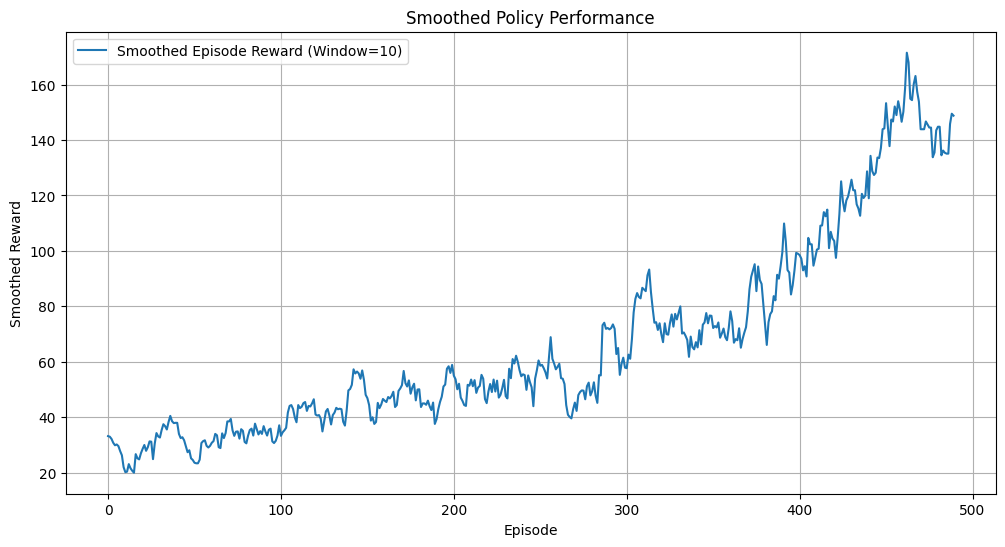

In [58]:
window_size = 10
smoothed_rewards = [np.mean(all_episode_rewards[i:i+window_size]) for i in range(len(all_episode_rewards)-window_size)]
plt.figure(figsize=(12,6))
plt.plot(smoothed_rewards, label='Smoothed Episode Reward (Window=10)')
plt.xlabel('Episode')
plt.ylabel('Smoothed Reward')
plt.title('Smoothed Policy Performance')
plt.grid(True)
plt.legend()
plt.show()


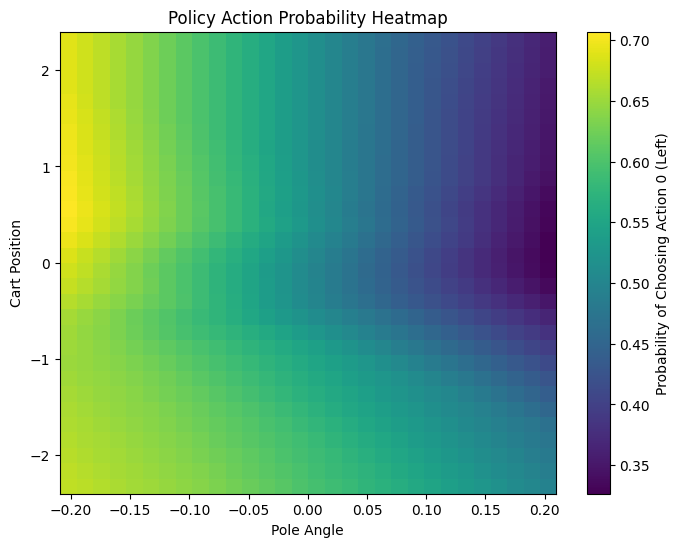

In [59]:
# Example visualization: action probabilities over a grid of "Cart Position" and "Pole Angle" (simplified)
import numpy as np

cart_positions = np.linspace(-2.4, 2.4, 30)
pole_angles = np.linspace(-0.20944, 0.20944, 30)  # ~12 degrees in radians
policy_map = np.zeros((len(cart_positions), len(pole_angles)))

for i, cp in enumerate(cart_positions):
    for j, pa in enumerate(pole_angles):
        # Construct a "representative" state with zero velocities
        state = np.array([cp, 0.0, pa, 0.0])
        state = np.expand_dims(state, axis=0)
        probs = model(state).numpy()[0]
        # Let's store the probability of choosing action 0 (go left)
        policy_map[i, j] = probs[0]

plt.figure(figsize=(8,6))
plt.imshow(policy_map, origin='lower', cmap='viridis', extent=[pole_angles[0], pole_angles[-1], cart_positions[0], cart_positions[-1]], aspect='auto')
plt.colorbar(label='Probability of Choosing Action 0 (Left)')
plt.xlabel('Pole Angle')
plt.ylabel('Cart Position')
plt.title('Policy Action Probability Heatmap')
plt.show()
